# Inteligência Artificial – Projeto 02

## Grupo 16

- Tiago Carneiro — nº 28002
- Alexandre Salyha — nº 27998

### Notebook 2 – Clustering (K-Means)

- Unidade Curricular: Inteligência Artificial  
- Ano letivo: 2025/2026  
- Tema: Segmentação de pilotos de Fórmula 1

**Objetivo deste notebook:**  
Aplicar o algoritmo K-Means para segmentar pilotos de Fórmula 1 com base em indicadores de desempenho (por exemplo: tempo médio de volta, número total de voltas, número e duração de pit stops), analisando e interpretando os clusters resultantes.

### Introdução

Este notebook corresponde ao **Notebook 2 – Clustering** do Projeto 02 da unidade curricular de Inteligência Artificial.

O objetivo deste trabalho é aplicar técnicas de *Machine Learning* não supervisionado, em particular o algoritmo **K-Means**, a dados de Fórmula 1, com o intuito de identificar grupos de pilotos com perfis de desempenho semelhantes. Ao contrário do Notebook 1, onde foi abordado um problema de classificação supervisionada, aqui não existe uma variável alvo explícita; o objetivo é descobrir padrões e estruturas latentes nos dados.

Ao longo deste notebook serão descritos o objetivo de negócio associado ao problema de clustering, o processo de preparação dos dados, a aplicação do algoritmo K-Means, a análise detalhada das características de cada cluster e a otimização de parâmetros, como o número de clusters. Serão ainda discutidos os resultados intermédios e finais obtidos.


### Importar bibliotecas

In [1]:
# Imports necessários para a parte de clustering (segmentação de pilotos)
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler   # normalização de features numéricas
from sklearn.cluster import KMeans                 # algoritmo de clustering K-Means
from sklearn.metrics import silhouette_score       # métrica de qualidade de clusters (Silhouette)

# Definir novamente o estilo dos gráficos, para garantir consistência
sns.set_theme()

### Objetivo de negócio

Do ponto de vista de negócio, o problema pode ser formulado da seguinte forma:

> **É possível identificar grupos de pilotos de Fórmula 1 com padrões de desempenho semelhantes, com base em métricas agregadas de corridas e voltas?**

Esta análise é relevante, por exemplo, para:
- distinguir pilotos mais consistentes de pilotos com desempenhos mais irregulares;
- identificar estilos de condução (mais rápidos mas arriscados, mais lentos mas estáveis, etc.);
- apoiar decisões estratégicas em equipas, comparando pilotos dentro e entre épocas.

Para tal, cada piloto é representado por um conjunto de **características agregadas**, calculadas a partir dos dados de tempos de volta e paragens nas boxes, permitindo aplicar um método de clustering que agrupe pilotos com comportamento semelhante em termos de ritmo de corrida e utilização de *pit stops*.


### Preparação dos dados

Para realizar o clustering, é necessário preparar um conjunto de dados em que cada linha represente **um piloto** e cada coluna corresponda a uma métrica quantitativa ou categórica do seu desempenho. Nesta análise são utilizados, principalmente, os seguintes ficheiros:

- `lap_times.csv` – contém registos de tempos de volta por corrida, piloto e volta;
- `pit_stops.csv` – contém informação sobre as paragens nas boxes, incluindo volta, número da paragem e duração.

A preparação dos dados segue, de forma geral, os seguintes passos:

1. **Seleção dos registos relevantes**  
   São consideradas apenas as colunas necessárias para o cálculo das métricas de interesse, tais como:
   - em `lap_times.csv`: `driverId`, `raceId`, `lap`, `milliseconds`;
   - em `pit_stops.csv`: `driverId`, `raceId`, `lap`, `milliseconds`.

   Na implementação, as métricas são calculadas a partir da coluna `milliseconds`, agregada por `driverId`.

2. **Cálculo de métricas agregadas por piloto**  
   Para cada piloto (`driverId`), são calculadas, entre outras, as seguintes estatísticas:
   - **Desempenho em corrida**
     - média do tempo por volta (`avg_lap_time`);
     - desvio padrão do tempo por volta (`std_lap_time`);
     - número total de voltas registadas (`num_laps`);
   - **Utilização de boxes**
     - número total de *pit stops* (`num_pit_stops`);
     - duração média das paragens em boxes (`avg_pit_time`).

   Estas métricas resultam da agregação das tabelas originais por piloto, combinando informação de várias corridas.

3. **Junção de informação de diferentes datasets**  
   As métricas provenientes de `lap_times.csv` e `pit_stops.csv` são combinadas numa única tabela, tendo como chave o identificador do piloto. Em seguida, são adicionadas informações adicionais (como o nome do piloto e a nacionalidade) a partir de `drivers.csv`, o que facilita a interpretação posterior dos clusters.

4. **Tratamento de valores em falta e filtragem de pilotos com poucos dados**  
   São analisados valores nulos nas métricas calculadas. Pilotos sem registos de *pit stops* têm o número de paragens (`num_pit_stops`) e o tempo médio de paragem (`avg_pit_time`) preenchidos com zero, distinguindo assim pilotos que nunca pararam nas boxes.  
   Além disso, são removidos da análise pilotos com **poucas voltas registadas** (por exemplo, menos de 50 voltas), por se considerar que não dispõem de informação suficiente para uma caracterização fiável. Esta filtragem contribui para reduzir distorções no processo de clustering.

5. **Seleção de variáveis para clustering**  
   As variáveis utilizadas diretamente no algoritmo K-Means são, tipicamente, numéricas, neste caso:
   - `avg_lap_time`;
   - `std_lap_time`;
   - `num_laps`;
   - `num_pit_stops`;
   - `avg_pit_time`.

   Variáveis categóricas (como nacionalidade) não são inseridas diretamente no modelo de clustering, mas são utilizadas posteriormente para analisar a distribuição de categorias por cluster.

6. **Normalização / padronização das variáveis numéricas**  
   Dado que o K-Means é sensível à escala dos dados, as variáveis numéricas são normalizadas (utilizando, por exemplo, o *StandardScaler*), de forma a garantir que todas contribuem de forma equilibrada para a distância utilizada pelo algoritmo.

Após estes passos, obtém-se um conjunto de dados preparado para a aplicação do algoritmo K-Means, em que cada linha representa um piloto e cada coluna representa uma característica quantitativa do seu desempenho.

### Carregar datasets

In [2]:
# Carregar os ficheiros necessários para construir métricas por piloto
lap_times = pd.read_csv("../dataset/lap_times.csv")
pit_stops = pd.read_csv("../dataset/pit_stops.csv")
drivers = pd.read_csv("../dataset/drivers.csv")  # inclui nomes e nacionalidade dos pilotos

# Mostrar o tamanho de cada dataset (nº de linhas e colunas)
print("lap_times:", lap_times.shape)
print("pit_stops:", pit_stops.shape)
print("drivers  :", drivers.shape)

display(lap_times.head())
display(pit_stops.head())
display(drivers.head())

lap_times: (613516, 6)
pit_stops: (12124, 7)
drivers  : (864, 9)


,raceId,driverId,lap,position,time,milliseconds
0,841,20,1,1,1:38.109,98109
1,841,20,2,1,1:33.006,93006
2,841,20,3,1,1:32.713,92713
3,841,20,4,1,1:32.803,92803
4,841,20,5,1,1:32.342,92342


,raceId,driverId,stop,lap,time,duration,milliseconds
0,841,153,1,1,17:05:23,26.898,26898
1,841,30,1,1,17:05:52,25.021,25021
2,841,17,1,11,17:20:48,23.426,23426
3,841,4,1,12,17:22:34,23.251,23251
4,841,13,1,13,17:24:10,23.842,23842


,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


### Métricas agregadas por piloto

In [3]:
# ============================
# Métricas a partir de lap_times
# ============================
lap_agg = (
    lap_times
    .groupby("driverId")["milliseconds"]   # agrupar por piloto (driverId)
    .agg(
        avg_lap_time="mean",              # tempo médio por volta
        std_lap_time="std",               # desvio padrão do tempo de volta (variabilidade)
        num_laps="count"                  # número total de voltas registadas
    )
)

# ============================
# Métricas a partir de pit_stops
# ============================
pit_agg = (
    pit_stops
    .groupby("driverId")["milliseconds"]  # agrupar por piloto
    .agg(
        avg_pit_time="mean",              # tempo médio de paragem nas boxes
        num_pit_stops="count"             # número de pit stops
    )
)

# Juntar métricas de voltas e de pit stops numa única tabela por piloto
driver_metrics = lap_agg.join(pit_agg, how="left")

# Substituir NaN em pilotos sem pit stops (assumir 0 paragens e 0 tempo médio)
driver_metrics["num_pit_stops"] = driver_metrics["num_pit_stops"].fillna(0)
driver_metrics["avg_pit_time"] = driver_metrics["avg_pit_time"].fillna(0)

# Colocar driverId novamente como coluna (em vez de índice)
driver_metrics = driver_metrics.reset_index()

# Ver as primeiras linhas das métricas por piloto
display(driver_metrics.head())

,driverId,avg_lap_time,std_lap_time,num_laps,avg_pit_time,num_pit_stops
0,1,96487.730096,73220.439662,21541,91524.931438,598.0
1,2,92514.578600,83944.547133,9701,22933.320000,25.0
2,3,98486.722695,95506.785938,11161,49760.690763,249.0
3,4,96007.920596,83254.511953,22971,91107.984314,510.0
4,5,100620.957796,113729.203375,5971,24608.666667,99.0


### Juntar nomes/nacionalidades e filtrar pilotos "com poucos dados"

In [4]:
# Selecionar algumas colunas da tabela de drivers para ter informação categórica adicional
drivers_small = drivers[["driverId", "forename", "surname", "nationality"]]

# Juntar (merge) as métricas numéricas com os nomes e nacionalidade
driver_metrics = driver_metrics.merge(drivers_small, on="driverId", how="left")

# Filtrar pilotos com poucas voltas: manter só quem tem pelo menos 50 voltas
min_laps = 50
driver_metrics = driver_metrics[driver_metrics["num_laps"] >= min_laps].copy()

print("Número de pilotos após filtro:", len(driver_metrics))
display(driver_metrics.head())

Número de pilotos após filtro: 143


,driverId,avg_lap_time,std_lap_time,num_laps,avg_pit_time,num_pit_stops,forename,surname,nationality
0,1,96487.730096,73220.439662,21541,91524.931438,598.0,Lewis,Hamilton,British
1,2,92514.578600,83944.547133,9701,22933.320000,25.0,Nick,Heidfeld,German
2,3,98486.722695,95506.785938,11161,49760.690763,249.0,Nico,Rosberg,German
3,4,96007.920596,83254.511953,22971,91107.984314,510.0,Fernando,Alonso,Spanish
4,5,100620.957796,113729.203375,5971,24608.666667,99.0,Heikki,Kovalainen,Finnish


### Selecionar features e normalizar

In [5]:
# Features numéricas que vão ser usadas no clustering
features = ["avg_lap_time", "std_lap_time", "num_laps", "num_pit_stops", "avg_pit_time"]

# Construir a matriz X apenas com essas features
X = driver_metrics[features].copy()

# Normalização / padronização das features (importante para K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Formato de X_scaled:", X_scaled.shape)  # (nº de pilotos, nº de features)

Formato de X_scaled: (143, 5)


### Aplicação e avaliação do algoritmo K-Means

Com os dados preparados, é aplicado o algoritmo **K-Means**, um dos métodos de clustering mais utilizados em *Machine Learning* não supervisionado. O K-Means procura particionar os pilotos em \(K\) grupos (clusters), de forma a minimizar a soma das distâncias quadráticas entre cada ponto e o centróide do cluster a que pertence.

A aplicação do K-Means segue, em termos gerais, os seguintes passos:

1. **Escolha do número de clusters (K)**  
   Em primeiro lugar, é necessário escolher um valor para \(K\). Neste notebook, parte-se de um valor inicial \(K = 4\), que é aplicado diretamente aos dados normalizados, e posteriormente é feita uma análise mais sistemática de vários valores de \(K\) (por exemplo, entre 2 e 10) na secção de otimização.

2. **Execução do algoritmo**  
   Para o valor de \(K\) considerado, o K-Means é ajustado aos dados normalizados (`X_scaled`), obtendo:
   - os centróides de cada cluster;
   - a atribuição de cada piloto a um dos clusters.

   No caso de \(K = 4\), os 143 pilotos são repartidos por quatro grupos distintos, e essa atribuição é armazenada na coluna `cluster` da tabela de métricas por piloto.

3. **Avaliação da qualidade do clustering**  
   A qualidade da partição obtida é avaliada com recurso ao **índice de Silhouette**, que mede simultaneamente a coesão intra-cluster e a separação entre clusters. Para \(K = 4\), foi obtido um valor de Silhouette score de aproximadamente **0.505**, o que indica uma separação razoavelmente boa entre os grupos.

   Numa fase posterior (na secção de otimização dos parâmetros), é realizada uma análise mais detalhada da qualidade do clustering para vários valores de \(K\), recorrendo quer à *inertia* (método do “cotovelo”), quer ao Silhouette score médio para cada valor de \(K\).

Além da avaliação quantitativa, a distribuição dos pilotos pelos clusters é também analisada visualmente, recorrendo a gráficos de dispersão (por exemplo, *pairplots*), onde diferentes pares de variáveis numéricas são representados e os pontos são coloridos de acordo com o cluster atribuído. Esta análise visual permite verificar se existem separações claras entre os grupos no espaço das variáveis consideradas.

In [6]:
# Valor inicial de K (número de clusters). Podes ajustar depois de analisar os resultados.
best_k = 4

# Criar o modelo K-Means com o K escolhido
kmeans = KMeans(
    n_clusters=best_k,
    random_state=42,  # para garantir reprodutibilidade dos clusters
    n_init=10         # número de inicializações diferentes (melhora estabilidade)
)

# Ajustar o modelo e obter os rótulos de cluster para cada piloto
cluster_labels = kmeans.fit_predict(X_scaled)

# Guardar o cluster atribuído a cada piloto no DataFrame
driver_metrics["cluster"] = cluster_labels

# Avaliar qualitativamente a qualidade dos clusters com o Silhouette score
sil_score = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette score para K={best_k}: {sil_score:.3f}")

Silhouette score para K=4: 0.505


### Visualização dos Clusters

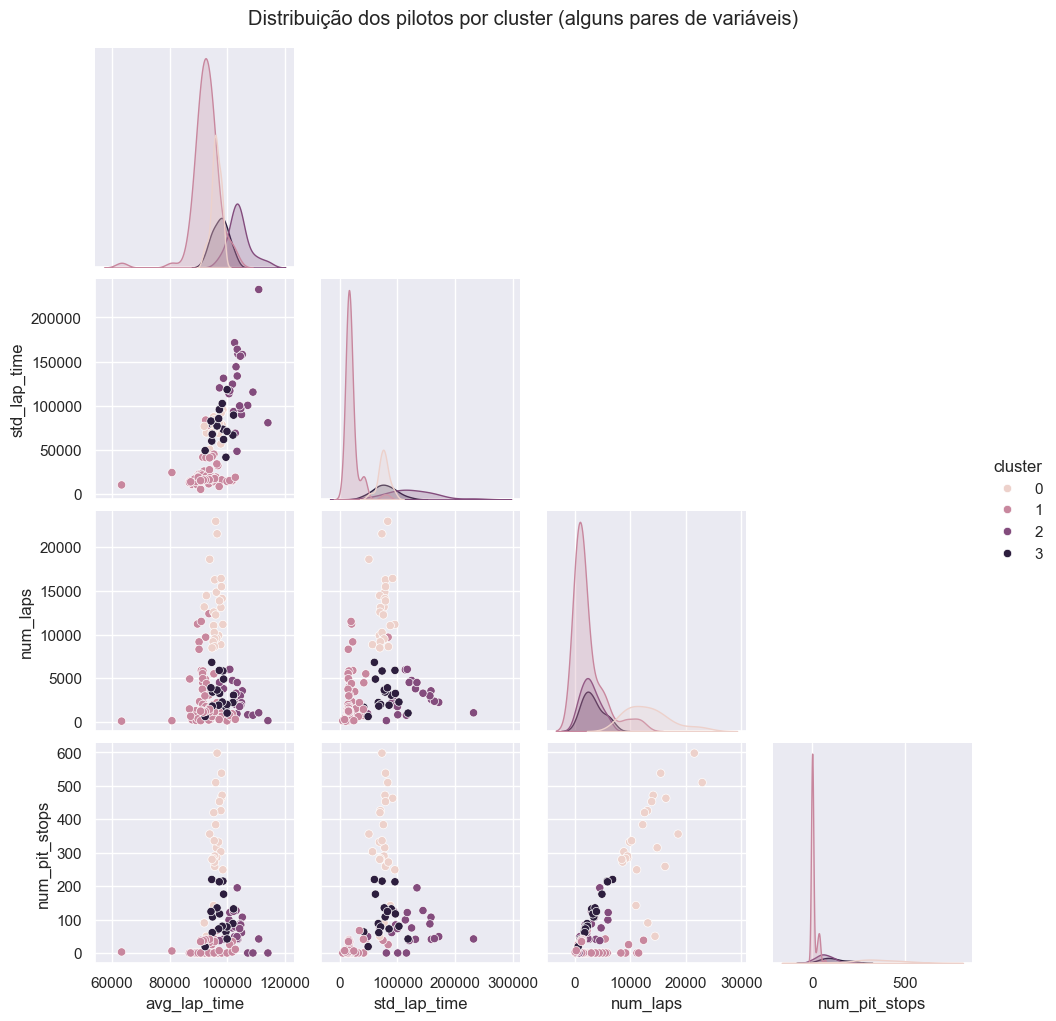

In [7]:
# Visualizar alguns pares de variáveis coloridos por cluster
sns.pairplot(
    driver_metrics,
    vars=["avg_lap_time", "std_lap_time", "num_laps", "num_pit_stops"],
    hue="cluster",
    corner=True
)
plt.suptitle("Distribuição dos pilotos por cluster (alguns pares de variáveis)", y=1.02)
plt.show()

### Análise das características de cada cluster

Após a definição do número de clusters mais apropriado, é realizada uma análise aprofundada das características de cada grupo de pilotos. Esta análise inclui:

1. **Número de elementos por cluster**  
   Para cada cluster, é contabilizado o número de pilotos atribuídos. Esta informação permite:
   - verificar se existem clusters muito pequenos (potenciais outliers);
   - identificar clusters dominantes com muitos elementos.

2. **Estatísticas das variáveis numéricas**  
   Para cada cluster, são calculadas estatísticas descritivas das variáveis numéricas utilizadas no clustering, tais como:
   - média;
   - desvio padrão;
   - valor mínimo;
   - valor máximo.

   A análise destas estatísticas permite caracterizar o perfil típico de cada cluster. Por exemplo:
   - um cluster com **`avg_lap_time` baixo** e **`num_pit_stops` reduzido** pode representar pilotos rápidos e eficientes;
   - um cluster com **`avg_lap_time` mais elevado** e **`std_lap_time` alto** pode indicar pilotos com desempenho mais irregular.

3. **Distribuição de variáveis categóricas (quando disponíveis)**  
   Embora não tenham sido utilizadas diretamente no K-Means, variáveis categóricas como a **nacionalidade dos pilotos** podem ser usadas para analisar a composição de cada cluster. Por exemplo:
   - verificar se determinados clusters são dominados por pilotos de certas equipas;
   - observar padrões geográficos ou de época.

A combinação destas análises permite interpretar os clusters não apenas em termos numéricos, mas também em termos de significado no contexto da Fórmula 1, identificando perfis de pilotos com características de desempenho semelhantes.


### Número de elementos por cluster

In [8]:
# Número de pilotos em cada cluster (para ver o equilíbrio entre grupos)
cluster_counts = driver_metrics["cluster"].value_counts().sort_index()
print("Número de pilotos por cluster:")
print(cluster_counts)

Número de pilotos por cluster:
cluster
0    24
1    80
2    22
3    17
Name: count, dtype: int64


### Estatísticas (média, std, min, max) das variáveis numéricas por cluster

In [9]:
# Calcular estatísticas descritivas das features numéricas por cluster
stats_por_cluster = (
    driver_metrics
    .groupby("cluster")[features]
    .agg(["mean", "std", "min", "max"])  # média, desvio padrão, mínimo e máximo
)

# Mostrar a tabela com estatísticas por cluster
stats_por_cluster

avg_lap_time                                            \
                  mean          std           min            max   
cluster                                                            
0         96046.937831  1654.195466  92023.120823   98486.722695   
1         92527.386309  4858.032950  63319.402299  102816.824503   
2        104038.746668  3750.187102  97307.132167  114121.786207   
3         97542.121562  2754.482424  92335.610749  102193.608511   

          std_lap_time                                             \
                  mean           std           min            max   
cluster                                                             
0         75652.639956   9729.578754  50781.689939   95506.785938   
1         20465.198126  12488.038460   5624.838080   83944.547133   
2        123605.603393  40294.767735  48598.546061  231547.012237   
3         77638.154775  19512.535319  41871.868270  118356.438233   

             num_laps                           num_pit_stops              \
                 mean          std   min    max          mean         std   
cluster                                                                     
0        13176.791667  3958.080815  8475  22971    337.750000  134.418959   
1         2272.950000  2797.895474    87  12396      6.762500   14.522130   
2         2778.772727  1649.317664   145   6022     69.727273   47.428324   
3         3191.705882  1796.079333   614   6818    114.294118   61.492647   

                       avg_pit_time                                             
          min    max           mean           std           min            max  
cluster                                                                         
0        50.0  598.0   82247.947534  34060.998639  22541.644444  140127.511029  
1         0.0   67.0    6602.802344  12647.224648      0.000000   58843.121951  
2         0.0  195.0   24168.889265  11056.048750      0.000000   40276.726027  
3        19.0  220.0  113353.347442  43068.752006  45499.676136  211286.047619

### Distribuição de uma variável categórica (ex.: nacionalidade)

In [10]:
# Distribuição das nacionalidades por cluster (top 5 nacionalidades em proporção por cluster)
dist_nationality = (
    driver_metrics
    .groupby("cluster")["nationality"]
    .value_counts(normalize=True)   # proporção em vez de contagem absoluta
    .rename("proporcao")
    .reset_index()
)

# Mostrar apenas as 5 nacionalidades mais frequentes em cada cluster
top5_nationality = (
    dist_nationality
    .groupby("cluster")
    .head(5)
)

display(top5_nationality)

,cluster,nationality,proporcao
0,0,British,0.166667
1,0,German,0.166667
2,0,French,0.125000
3,0,Australian,0.083333
4,0,Brazilian,0.083333
12,1,Brazilian,0.137500
13,1,British,0.137500
14,1,Italian,0.137500
15,1,French,0.062500
16,1,Japanese,0.062500


### Otimização dos parâmetros do K-Means

A escolha dos parâmetros do algoritmo K-Means, em particular o número de clusters \(K\), tem um impacto direto na qualidade do clustering. Assim, é realizada uma fase de otimização que inclui:

1. **Exploração de diferentes valores de K**  
   São testados vários valores de \(K\) (por exemplo, entre 2 e 10), calculando-se para cada um:
   - a *inertia* (soma das distâncias intra-cluster);
   - o índice de Silhouette médio.

2. **Método do cotovelo (elbow method)**  
   A *inertia* é representada graficamente em função de \(K\). Procura-se identificar um “cotovelo” na curva, ou seja, um ponto a partir do qual o decréscimo de *inertia* passa a ser menos acentuado. Esse ponto é um bom candidato para o número adequado de clusters.

3. **Análise do índice de Silhouette**  
   Para cada \(K\), é calculado o valor médio do índice de Silhouette. Valores mais elevados indicam clusters mais bem separados e coesos. Este indicador complementa a análise do cotovelo, ajudando a escolher o valor de \(K\) que melhor equilibra coesão interna e separação entre grupos.

4. **Escolha do modelo final**  
   Com base nas análises anteriores, concluiu-se que valores de \(K\) em torno de 4 apresentam um bom compromisso entre redução de *inertia* (cotovelo da curva) e Silhouette score elevado. Assim, foi escolhido **\(K = 4\)** como número de clusters para o modelo final, e o K-Means foi ajustado em definitivo aos dados com este valor. A partir deste modelo final, procede-se à análise das características dos clusters, tal como descrito na secção anterior.

Esta abordagem sistemática à escolha de \(K\) contribui para uma solução de clustering mais robusta e interpretável.

### Método do cotovelo (elbow method)

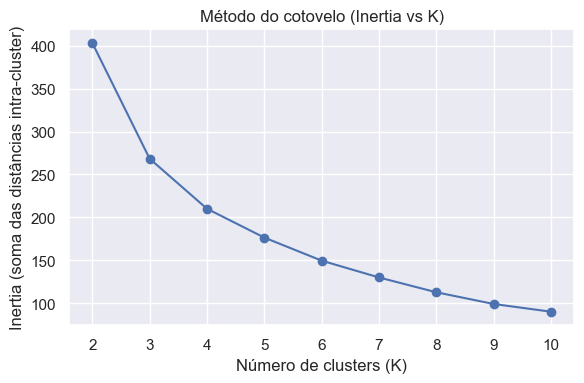

In [11]:
# Intervalo de valores de K a testar (número de clusters)
K_range = range(2, 11)  # K de 2 até 10

inertias = []  # lista para guardar a inércia para cada K

# Para cada K, ajustar um modelo K-Means e guardar a inércia (soma das distâncias intra-cluster)
for k in K_range:
    kmeans_k = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    kmeans_k.fit(X_scaled)
    inertias.append(kmeans_k.inertia_)

# Gráfico do método do cotovelo: ajuda a escolher um K "razoável"
plt.figure(figsize=(6, 4))
plt.plot(list(K_range), inertias, marker="o")
plt.title("Método do cotovelo (Inertia vs K)")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inertia (soma das distâncias intra-cluster)")
plt.tight_layout()
plt.show()

### Análise do índice de Silhouette

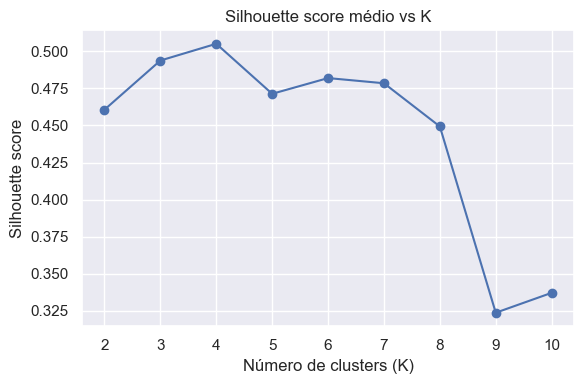

K = 2: Silhouette = 0.461
K = 3: Silhouette = 0.494
K = 4: Silhouette = 0.505
K = 5: Silhouette = 0.471
K = 6: Silhouette = 0.482
K = 7: Silhouette = 0.478
K = 8: Silhouette = 0.449
K = 9: Silhouette = 0.324
K = 10: Silhouette = 0.337


In [12]:
# Lista para guardar o Silhouette score médio para cada K
silhouette_scores = []

# Calcular Silhouette score para cada valor de K em K_range
for k in K_range:
    kmeans_k = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    labels_k = kmeans_k.fit_predict(X_scaled)
    sil_k = silhouette_score(X_scaled, labels_k)
    silhouette_scores.append(sil_k)

# Gráfico do Silhouette score médio em função de K:
# valores mais altos indicam melhor separação entre clusters.
plt.figure(figsize=(6, 4))
plt.plot(list(K_range), silhouette_scores, marker="o")
plt.title("Silhouette score médio vs K")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Silhouette score")
plt.tight_layout()
plt.show()

# Mostrar também os valores numéricos
for k, sil in zip(K_range, silhouette_scores):
    print(f"K = {k}: Silhouette = {sil:.3f}")

### Escolha do modelo final

In [13]:
# Exemplo: K=4 com base nas análises anteriores (cotovelo + Silhouette)
best_k = 4

# Criar e treinar o modelo final de K-Means com o K escolhido
kmeans_final = KMeans(
    n_clusters=best_k,
    random_state=42,
    n_init=10
)

# Atribuir o cluster final a cada piloto e guardar no DataFrame
driver_metrics["cluster"] = kmeans_final.fit_predict(X_scaled)

print("Modelo final ajustado com K =", best_k)

Modelo final ajustado com K = 4


### Resultados e considerações finais

Neste notebook foi aplicado o algoritmo K-Means a um conjunto de **143 pilotos** de Fórmula 1, descritos por métricas agregadas de desempenho, nomeadamente: tempo médio de volta (`avg_lap_time`), desvio padrão do tempo de volta (`std_lap_time`), número total de voltas (`num_laps`), número de paragens nas boxes (`num_pit_stops`) e tempo médio de paragem (`avg_pit_time`). Após a normalização das variáveis e a exploração de diferentes valores de \(K\), foi selecionado **\(K = 4\)** como número de clusters, com um **Silhouette score de aproximadamente 0.505**, o que indica uma separação razoavelmente boa entre os grupos.

Os quatro clusters obtidos apresentam os seguintes tamanhos:

- **Cluster 0** – 24 pilotos  
- **Cluster 1** – 80 pilotos  
- **Cluster 2** – 22 pilotos  
- **Cluster 3** – 17 pilotos  

A análise das estatísticas descritivas por cluster permite identificar **perfis distintos de pilotos**:

- O **cluster 1** reúne a maioria dos pilotos, com **tempos médios de volta mais baixos** e desvio padrão relativamente reduzido, sugerindo um grupo de pilotos **globalmente rápidos e consistentes**, com um número moderado de voltas e poucas paragens nas boxes.

- O **cluster 0** agrupa pilotos com **muito mais voltas e número elevado de *pit stops***, bem como tempos médios de paragem relativamente altos. Este perfil é compatível com pilotos com **carreiras mais longas** e maior utilização das boxes ao longo do tempo, ainda que com desempenho em corrida menos destacado do que o cluster 1.

- O **cluster 2** é caracterizado por **tempos médios de volta mais elevados** e por um **desvio padrão muito grande**, indicando pilotos **mais lentos e irregulares**. O número de voltas e de *pit stops* é intermédio, mas a combinação de tempo médio alto e elevada variabilidade sugere um desempenho menos competitivo.

- O **cluster 3** apresenta tempos médios de volta na gama intermédia, mas distingue-se por **tempos médios de *pit stop* bastante altos** e um número também significativo de paragens, apontando para pilotos associados a contextos de corrida em que as paragens nas boxes são particularmente demoradas (por exemplo, épocas ou estratégias específicas).

A análise da distribuição de **nacionalidades** dentro de cada cluster mostra que não existe domínio absoluto de um único país em nenhum grupo. Nacionalidades como britânica, alemã, francesa e brasileira surgem em vários clusters, o que indica que o algoritmo está a agrupar principalmente com base em **padrões de desempenho em pista e utilização das boxes**, e não em fatores geográficos.

Em síntese, os resultados demonstram que o K-Means consegue identificar **grupos coerentes de pilotos** com comportamentos diferenciados em termos de ritmo de corrida, regularidade e estratégias de paragem. Apesar de o modelo utilizar apenas um conjunto limitado de métricas agregadas, os clusters obtidos são interpretáveis e fornecem uma visão útil sobre diferentes perfis de desempenho na Fórmula 1.

Como trabalho futuro, seria interessante:
- incorporar variáveis adicionais, como características dos circuitos, épocas ou equipas;
- experimentar outros algoritmos de clustering (por exemplo, DBSCAN ou Birch) e comparar a estrutura dos grupos;
- analisar a estabilidade dos clusters ao longo de diferentes períodos temporais ou subconjuntos de corridas.

Esta secção conclui o **Notebook 2 – Clustering**, complementando a análise supervisionada realizada no Notebook 1 com uma perspetiva não supervisionada sobre os padrões de desempenho dos pilotos.